In [1]:
# Please run this notebook in python version >= '3.5'
# Also uploaded to a online Colab Notebook: https://colab.research.google.com/drive/17bQFZw8fokRn85iJc3hFRy-hJ45DvJ2S?usp=sharing

# All imports required to run the code

from math import pi, tan

import abc
import collections
import functools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
from typing import Tuple

%matplotlib inline

In [2]:
# All CONSTANTS used in the notebook

# Set the path to the images
PATH = pathlib.Path('~/Downloads').expanduser()
AERIAL_PATH = PATH / '5.1.10.tiff'
AIRPORT_PATH = PATH / '5.3.02.tiff'
APC_PATH = PATH / '7.1.08.tiff'

# Rest of the code will use `TEST_IMG_PATH`
# Change the value below to test different images 
TEST_IMG_PATH = APC_PATH

# Other constants used
BITS_PER_PIXEL = 8
MAX_PIXEL_VALUE = 1 << BITS_PER_PIXEL

EXPERMENTAL_VALUE = {
    'Aerial': (AERIAL_PATH, 150),
    'Airport': (AIRPORT_PATH, 80),
    'APC':  (APC_PATH, 60)
}

# Q1 The Human Eye

In [3]:
def get_optimal_distance(
    *,
    size: Tuple[int, int],
    resolution: Tuple[int, int],
    spacial_freq: int = 60,
):
    """Returns the optimal distance from T.V"""
    w = spacial_freq * 2 * size[0] / resolution[0]
    optimal_dist = w / (2 * tan(pi/360))
    return optimal_dist

In [4]:
def solve():
    try:
        width = int(input('Enter Width of T.V: '))
        height = int(input('Enter Height of T.V: '))
        resolution_x, resolution_y = map(int ,input('Enter resolution of TV (e.g. 1920 1080): ').split())
        if resolution_x <=0 or resolution_y <=0:
            print('Resolution cannot be zero.')
            raise Exception()
        distance = int(input('Enter available distance between couch and TV: '))
        opt_dist = get_optimal_distance(size=(width, height), resolution=(resolution_x, resolution_y))
        if opt_dist > distance:
            print(f'Optimal_dist {opt_dist} is more than the available distance {distance}')
        else:
            print(f'Optimal_dist is {opt_dist}')

    except:
        print('Incorrect input. Please try again')
        solve()

In [5]:
solve()

# Q2 The Basics

## Q2.1 and Q2.2 

* Read the contents of an image into an array 
* Display the image.

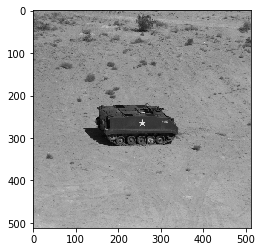

In [5]:
img = mpimg.imread(TEST_IMG_PATH)
plt.imshow(img, cmap='gray')
plt.show()

## Q2.3, Q2.4, Q2.5

* Print the maximum and minimum pixel values of I. Based on these values how many bits are needed (used) per pixel?  
* What is the resolution of I?  
* What is the size of the compressed image you downloaded?  

In [6]:
max_val, min_val = np.max(img), np.min(img)
print(f'Max Value = {max_val}, Min Value = {min_val}')

bits_required = 0
bit_range = max_val - min_val + 1
while bit_range != 0:
    bit_range = bit_range // 2
    bits_required += 1
print(f'Minimum bits per pixel required to store image without any lost of information = {bits_required}')

print(f'Resolution of the image: {img.shape}')

img_size = functools.reduce(lambda num1, num2: num1 * num2, img.shape, 1)
print(f'Size of the compressed image in bytes = {img_size}')


Max Value = 215, Min Value = 12
Minimum bits per pixel required to store image without any lost of information = 8
Resolution of the image: (512, 512)
Size of the compressed image in bytes = 262144


In [7]:
compression = TEST_IMG_PATH.stat().st_size / img_size
print(f'Compression rate: {compression}')

Compression rate: 1.0005111694335938


## Q2.6
Based on the previous answers and assuming 256 gray levels, how efficienctly is the image compressed for storage?

**Ans:**
The size of the image is slightly higher then the size of array.
Because a file on a computer has some additional metadata stored in it.


## Q2.7
Display each bitplane of the image I as a binary image.

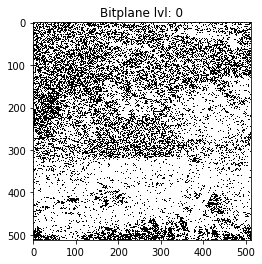

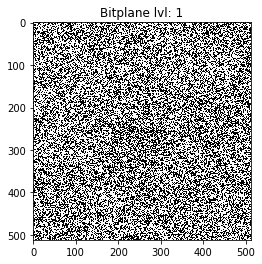

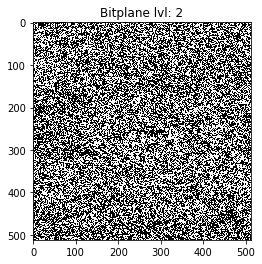

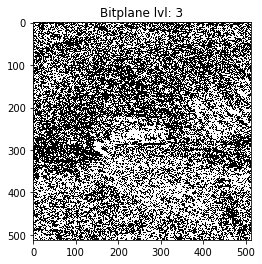

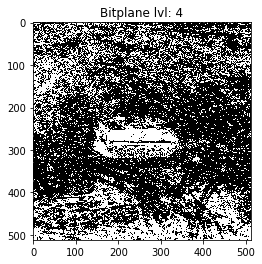

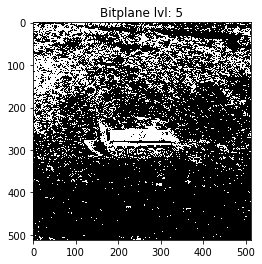

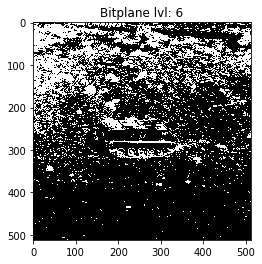

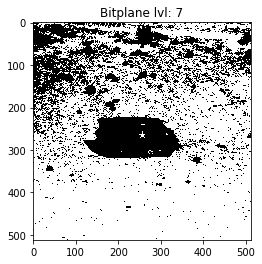

In [8]:
bitplane_array = np.vectorize(functools.partial(np.binary_repr, width=BITS_PER_PIXEL))(img)

def get_bitplane(bitplane, n):
    """Returns the nth level of the bitplane

    Attributes: 
        bitplane (numpy.ndarray): The binary_repr of each pixel of image input.
        n (int): Index of the bitplane (0 <= n < BITS_PER_PIXEL)
    
    Returns:
        (numpy.ndarray): Returns the nth bit plane
    """
    lvl = BITS_PER_PIXEL - n - 1
    return np.vectorize(lambda s: s[lvl])(bitplane).astype(np.int)

for lvl in range(BITS_PER_PIXEL):
    plt.figure()
    plt.imshow(get_bitplane(bitplane_array, lvl), cmap='gray')
    plt.title(f'Bitplane lvl: {lvl}')

## Q 2.8
Starting with the lowest bitplane, set each bitplane to 0 and display the resulting gray scale image (you will ultimately display a black image). Can you draw any conclusions on the importance of one bitplane over another?

**Ans:**

The ending layer have more important information because
* When we unset the lower layers, there is no significant change in the image.
* Drastic change is observered when we unset the higher layers.

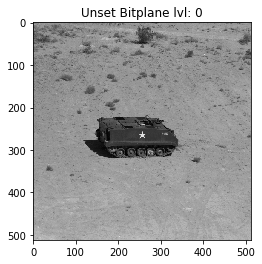

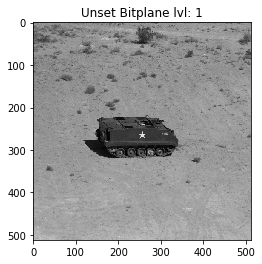

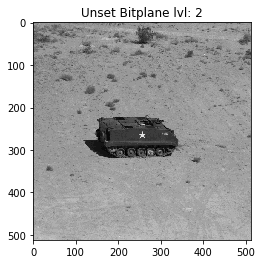

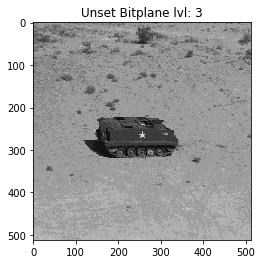

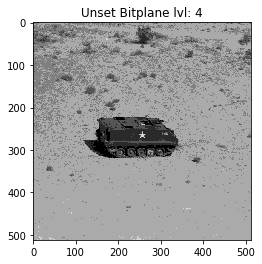

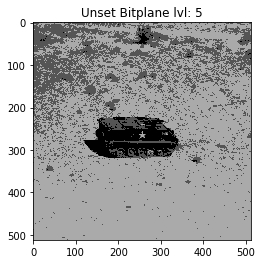

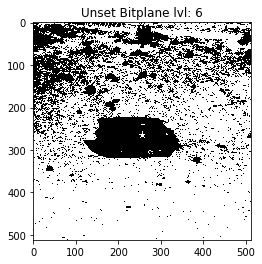

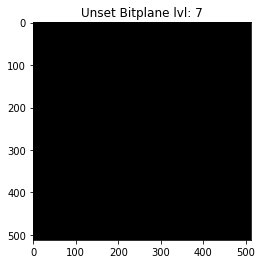

In [9]:
def unset_bitplane(array, n):
    """Set nth level of bitplane to zero"""
    return np.vectorize(lambda num: num & (~(1 << n)))(array)

tmp = img
for lvl in range(8):
    plt.figure()
    tmp = unset_bitplane(tmp, lvl)
    plt.imshow(tmp, cmap='gray')
    plt.title(f'Unset Bitplane lvl: {lvl}')

Q 2.9
Starting with 256 gray levels (8 bits per pixel), decrease the quantization level by 1 bit per pixel until you reach 2 gray levels. Re-quantize at each rate and display the resulting image.

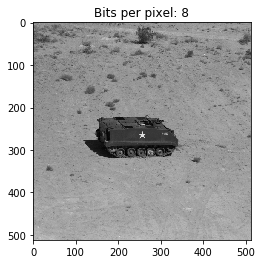

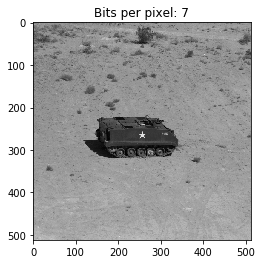

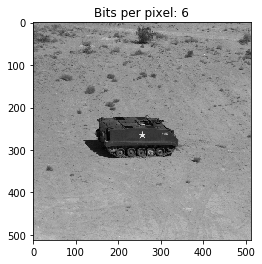

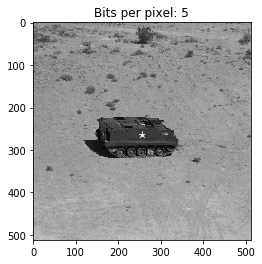

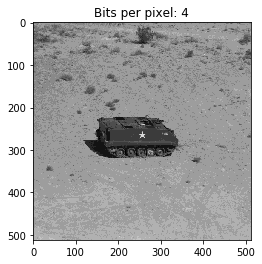

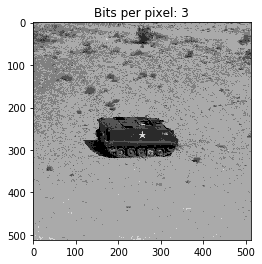

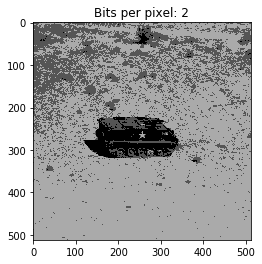

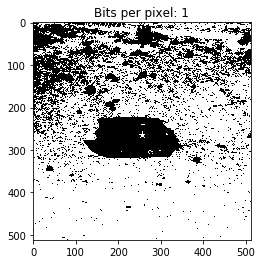

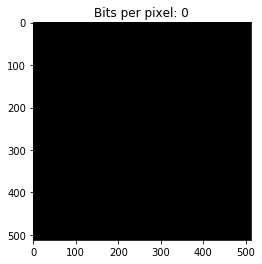

In [10]:
tmp = np.copy(img)
for bits in range(BITS_PER_PIXEL, -1, -1):
    plt.figure()
    plt.imshow(tmp, cmap='gray')
    plt.title(f'Bits per pixel: {bits}')
    tmp = tmp >> 1;

# Q3 Binary Morphology

## Q3.1
Write a function to compute the histogram of an image and plot the same. What is the modality of the histogram for the images mentioned above?

**Ans**:

(This is valid only for)

* Aerial --> Bimodal
* Airport --> Unimodal
* APC --> Unimodal


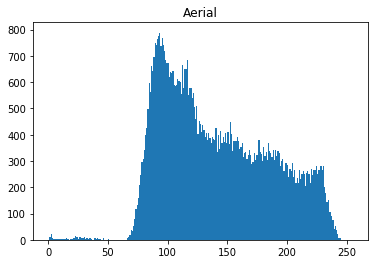

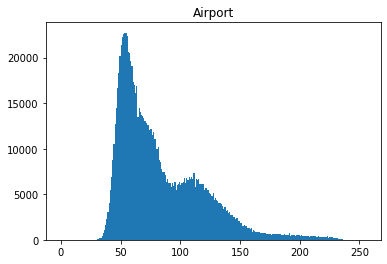

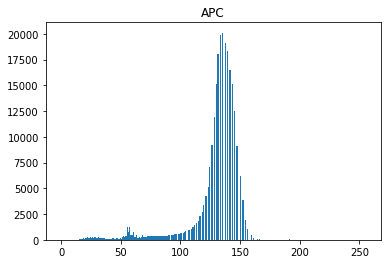

In [11]:
for name, value in EXPERMENTAL_VALUE.items():
    temp = mpimg.imread(value[0])
    plt.figure()
    plt.hist(temp.flatten(), bins = range(256))
    plt.title(f'{name}') 
    plt.show()

## Q3.2
Binarize I using the above histogram following the modal thresholding approach discussed in class. Compare this image with the binary image in the last step of the previous problem.

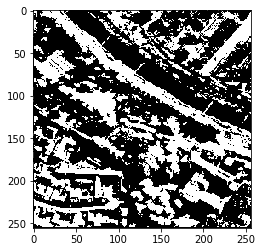

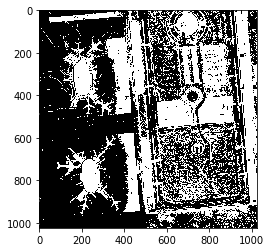

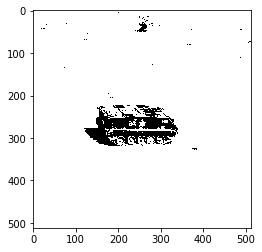

In [12]:
for name, value in EXPERMENTAL_VALUE.items():
    temp = mpimg.imread(value[0])
    b_img = (temp > value[1]).astype(int)
    plt.imshow(b_img, cmap='gray')
    plt.show()

In [13]:
def complement(img):
    """Return complement of a binary image"""
    return np.vectorize(lambda x: not x)(img).astype(int)

def valid(x, y, shape):
    """Returns True, if indices are within the bounds"""
    return (0 <= x < shape[0]) and (0 <= y < shape[1])

def visit(node, adj_list, visited, k, index):
    """Visits a node and marks the index while performing DFS"""
    if visited[node]:
        return
    visited[node] = True
    index[node] = k
    for n in adj_list[node]:
        visit(n, adj_list, visited, k, index)
    return

def dfs(adj_list):
    """Performs DFS to find connected components"""
    n = len(adj_list)
    visited = [False] * n
    index = [0] * n
    k = 0
    for i in range(n):
        if not visited[i]:
            visit(i, adj_list, visited, k, index)
            k += 1
    return index

def remove_small_blob(img, regions, in_place = False):
    """Removes smaller blobs"""
    res = img if in_place else np.copy(img)
    m = collections.Counter(regions[img.astype('bool')]).most_common(1)[0][0]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 1 and regions[i][j] != m:
                res[i][j] = 0
    return res

def remove_blobs(binarized_img):
    """Removes smaller blobs"""
    regions = get_regions(binarized_img)
    comp_img = complement(binarized_img)
    remove_small_blob(comp_img, regions, in_place = True)
    comp_img = complement(comp_img)
    return comp_img

def get_regions(img):
    k = 0  # Region number counter
    R = np.zeros(img.shape).astype('int64')  # Region color array
    adj_list = collections.defaultdict(set)  # Adjaceny list to link regions
    R[0][0] = k
    adj_list[k] = set()
    k += 1
    for i in range(1, R.shape[0]):
        if img[i][0] != img[i-1][0]:
            R[i][0] = k
            adj_list[k] = set()
            k += 1
        else:
            R[i][0] = R[i-1][0]
    for j in range(1, R.shape[1]):
        if img[0][j] != img[0][j-1]:
            R[0][j] = k
            adj_list[k] = set()
            k += 1
        else:
            R[0][j] = R[0][j-1]
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if img[i][j] != img[i-1][j] and img[i][j] != img[i][j-1]:
                R[i][j] = k
                adj_list[k] = set()
                k += 1
            if img[i][j] == img[i-1][j]:
                R[i][j] = R[i-1][j]
            if img[i][j] == img[i][j-1]:
                R[i][j] = R[i][j-1]
            if img[i][j] == img[i-1][j] and img[i][j] == img[i][j-1]:
                if R[i-1][j] != R[i][j-1]:
                    adj_list[R[i-1][j]].add(R[i][j-1])
                    adj_list[R[i][j-1]].add(R[i-1][j])
                R[i][j] = min(R[i-1][j], R[i][j-1])
    index = dfs(adj_list)
    return np.vectorize(lambda x: index[x])(R)

## Q 3.3 and Q 3.4
* Implement the connected components algorithm and use it to label the binarized version of I.
* Implement minor blob removal to get rid of minor blobs.

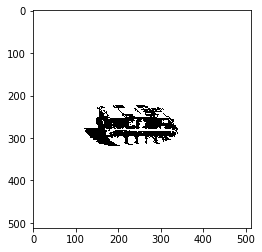

In [14]:
# Uncomment the line below and change values to test for more images.
# b_img = (mpimg.imread(EXPERMENTAL_VALUE['APC']) > EXPERMENTAL_VALUE['APC'][1]).astype(int)

no_blob_img = remove_blobs(b_img) 
plt.imshow(no_blob_img, cmap='gray')
plt.show()

In [15]:
class StructuringElement(abc.ABC):

    def __init__(self, count):
        self.count = count

    @property
    @abc.abstractmethod
    def relative_coordinates(self):
        pass


In [16]:
class Cross(StructuringElement):

    @property
    def relative_coordinates(self):
        mid = self.count//2
        return {(0, i) for i in range(-mid, mid + 1)} | {(i, 0) for i in range(-mid, mid + 1)}

class Square(StructuringElement):

    @property
    def relative_coordinates(self):
        mid = self.count//2
        rel_coords = set()
        for i in range(-mid, mid + 1):
            for j in range(-mid, mid + 1):
                rel_coords.add((i,j))
        return rel_coords

In [17]:
class BinaryFilter(abc.ABC):

    @abc.abstractmethod
    def operation(self, windowed_set):
        pass

    def get_image_values(self, coordinates, img, x, y):
        return [img[i][j] for (i, j) in map(lambda point: (x + point[0], y + point[1]), coordinates) if valid(i, j, img.shape)]
    
    def run(self, coordinates, img):
        res = np.zeros(img.shape)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                res[i][j] = self.operation(self.get_image_values(coordinates, img, i, j))
        return res

In [18]:
class Dilation(BinaryFilter):
    def operation(self, windowed_set):
        return int(any(windowed_set))

class Erosion(BinaryFilter):
    def operation(self, windowed_set):
        return int(all(windowed_set))

class Median(BinaryFilter):
    def operation(self, windowed_set):
        return (lambda x: x[len(x)//2])(sorted(windowed_set))

## Q 3.5. 
Now implement the following filters that take a binary image I and window B as inputs: DILATE, ERODE, MEDIAN.  
Filter the above binary image using the following windows B = CROSS(5), B = SQUARE(3).

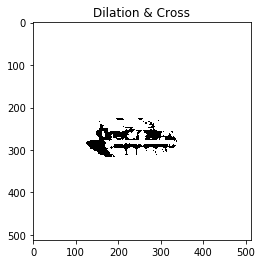

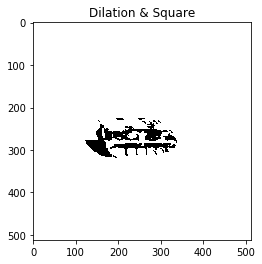

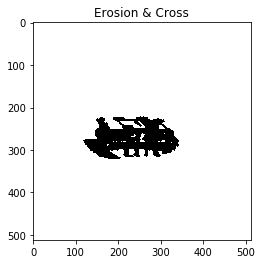

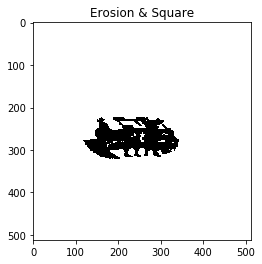

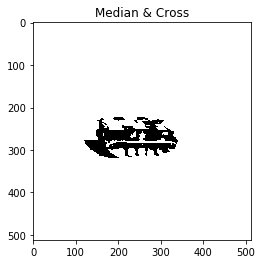

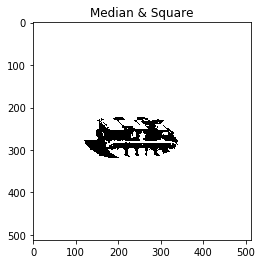

In [19]:
for f in [Dilation(), Erosion(), Median()]:
    for w in [Cross(5), Square(3)]:
        filtered_img = f.run(w.relative_coordinates, no_blob_img)
        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title(f'{type(f).__name__} & {type(w).__name__}')

In [20]:
def Open(coordinate, img):
    return Dilation().run(coordinate, Erosion().run(coordinate, img))

def Close(coordinate, img):
    return Erosion().run(coordinate, Dilation().run(coordinate, img))

## Q 3.6
Implement the compound operators OPEN and CLOSE using the basic filters implemented above.  
Filter the binary image from the problem before last using the same windows as above.

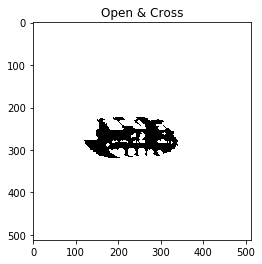

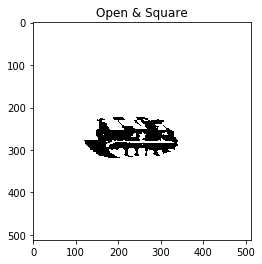

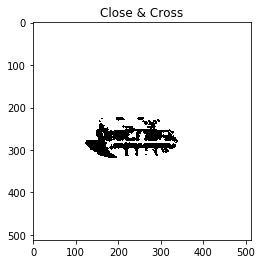

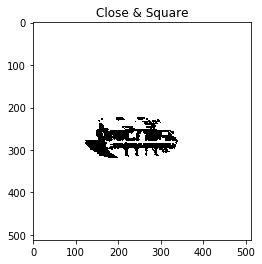

In [21]:
for f in [Open, Close]:
    for w in [Cross(5), Square(3)]:
        filtered_img = f(w.relative_coordinates, no_blob_img)
        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title(f'{f.__name__} & {type(w).__name__}')

In [22]:
def OpenClose(coordinate, img):
    return Open(coordinate, Close(coordinate, img))

def CloseOpen(coordinate, img):
    return Close(coordinate, Open(coordinate, img))

## Q3.7
Finally, implement OPEN-CLOS and CLOS-OPEN. Filter the binary image using the same windows as above.

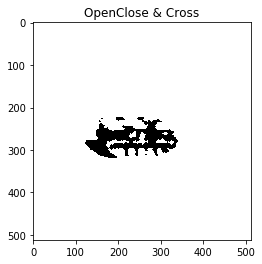

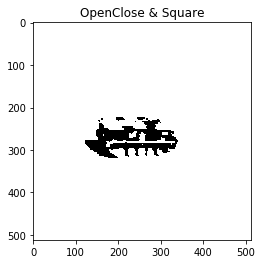

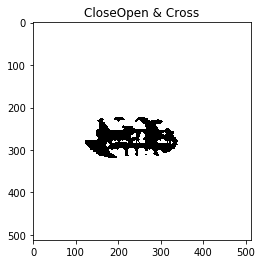

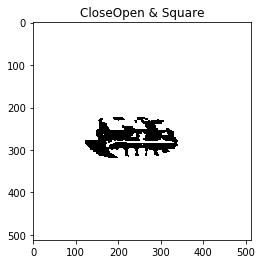

In [23]:
for f in [OpenClose, CloseOpen]:
    for w in [Cross(5), Square(3)]:
        filtered_img = f(w.relative_coordinates, no_blob_img)
        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title(f'{f.__name__} & {type(w).__name__}')

## Q3.8
For the APC image, count the number of pixels in the object of interest - i.e., the military vehicle.

In [28]:
print(f'No. of pixels in the object of interest = {np.sum(no_blob_img == 0)}')

No. of pixels in the object of interest = 10486
